## **GNN AND LSTM PROJECT USING TENSORFLOW AND KERAS**

The main objective of this project is to predict traffic speed on a road network using advanced artificial intelligence techniques, combining Graphical Neural Networks (GNN) and Long-Term Memory Networks (LSTM).

- GNNs are ideal for modelling data that have a graph structure, such as road networks. They can capture the spatial relationships and interactions between different road segments (nodes) by considering the structure of the network. GNNs allow information to propagate through the network, which helps to capture how traffic on one road segment can influence adjacent segments.

- LSTMs are a type of recurrent neural network (RNN) that can remember information over long periods of time. They are particularly useful for capturing the evolution of traffic speed over time. LSTMs can handle sequential data and make predictions based on temporal patterns, which is essential for predicting future changes in traffic speed.

The model is designed to predict traffic speeds at different nodes of the road network. It uses past speeds and the structure of the road network (represented by the distance matrix) to make these predictions.

In [49]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import ops

- This traffic speed prediction project uses data on distances between nodes (monitoring points) and historical traffic speed data.
- The data is normalised and then fed into a combined GNN and LSTM model.
- GNNs allow the model to consider the spatial structure of the road network, while LSTMs capture temporal dependencies in traffic speeds, allowing for more accurate predictions of future speeds on the traffic network.

### CREATE THE DATASET SIMULATING A TRAFFIC ENVIRONMENT WITH RANDOM DATA

- **Route_distances**: matrix representing the distances between different nodes (road segments) in the road network. Each entry in the matrix indicates the distance between a specific pair of nodes.

- **Speeds_Array**: matrix containing the historical traffic speeds at each node in the network.
Each entry in the matrix represents the traffic speed at a node at a given time.

In [50]:
N = 10 # the number of nodes in the traffic network representing intersections in the road network
T = 150 # number of moments of time at which the traffic speed is measured

# generating a random symmetric distance matrix
route_distances = np.random.rand(N, N) * 10000

# ensures that the distance matrix is symmetric by adding the original matrix and its transpose, then dividing by 2
route_distances = (route_distances + route_distances.T) / 2
np.fill_diagonal(route_distances, 0) # the distance of a node from itself is zero

# Generate random speeds in the range [20, 80] km/h
speeds_matrix = np.random.uniform(20, 80, size=(T, N))

In [51]:
route_distances

array([[   0.        , 4875.61099045, 6125.20484458, 6325.02607882,
        7021.33973213, 3510.59413792, 4298.82167512, 7404.81953612,
        5598.83185438, 8630.37533346],
       [4875.61099045,    0.        , 4703.36229843, 5982.37685587,
        4782.2967349 , 7455.16617166, 5808.4916287 , 3659.96888665,
        2436.1967893 , 7029.60199224],
       [6125.20484458, 4703.36229843,    0.        , 3041.67499173,
        7962.89439668, 3972.66030261, 7011.81247862, 4728.23549102,
        2602.29892312, 4389.67936785],
       [6325.02607882, 5982.37685587, 3041.67499173,    0.        ,
        2933.22256119, 2290.54111289, 7581.11065519, 5416.744177  ,
        2541.23852471, 4853.02733904],
       [7021.33973213, 4782.2967349 , 7962.89439668, 2933.22256119,
           0.        , 2557.54732713, 7285.47546703, 5976.41675315,
        5184.07536817, 4625.82240911],
       [3510.59413792, 7455.16617166, 3972.66030261, 2290.54111289,
        2557.54732713,    0.        , 4192.05353387, 5245

In [52]:
speeds_matrix

array([[53.89113068, 52.10928569, 33.79370393, ..., 31.9967276 ,
        61.35909208, 49.14985333],
       [38.51264762, 78.23269657, 29.61204463, ..., 58.3344341 ,
        57.84234546, 24.58666197],
       [59.80926493, 79.31065627, 31.26152133, ..., 62.60864337,
        50.04247184, 20.02084535],
       ...,
       [46.25229013, 74.68236486, 44.49130625, ..., 74.42184939,
        65.43894607, 73.7206895 ],
       [23.00684372, 34.61052194, 69.50737494, ..., 32.38087113,
        36.22299376, 62.35085449],
       [79.95908265, 56.336387  , 43.86554894, ..., 21.11870085,
        65.92444872, 75.72650846]])

In [53]:
print("Route Distances", route_distances.shape)
print("Speed Matrix", speeds_matrix.shape)

Route Distances (10, 10)
Speed Matrix (150, 10)


### DATA NORMALISATION

Normalisation is a crucial step in data pre-processing for deep learning models, as it helps to improve model performance and stability.

In [54]:
from sklearn.preprocessing import StandardScaler

# divides each element by the maximum value in the matrix. This scales the values of the distance matrix to the range [0, 1]
route_distances_n = route_distances / np.max(route_distances)

# rearranges the velocity matrix to a 2D shape
scaler = StandardScaler()
speeds_matrix_n = scaler.fit_transform(speeds_matrix.reshape(-1, N)).reshape(T, N, 1)

### CONSTRUCTION OF THE MODEL

In [55]:
from sklearn.model_selection import train_test_split

# split data into training and test
X = speeds_matrix_n[:-1]
y = speeds_matrix_n[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# expands the adjacency matrix to match the number of samples in X_train and X_test
# Add a new dimension to the beginning of the matrix by converting it to (1, N, N).
route_distances_expanded_train = np.expand_dims(route_distances_n, axis=0)

# duplicate the array along the first axis to match the number of samples in X_train (num_samples_train, N, N)
route_distances_expanded_train = np.repeat(route_distances_expanded_train, X_train.shape[0], axis=0)

# same with test
route_distances_expanded_test = np.expand_dims(route_distances_n, axis=0)
route_distances_expanded_test = np.repeat(route_distances_expanded_test, X_test.shape[0], axis=0)

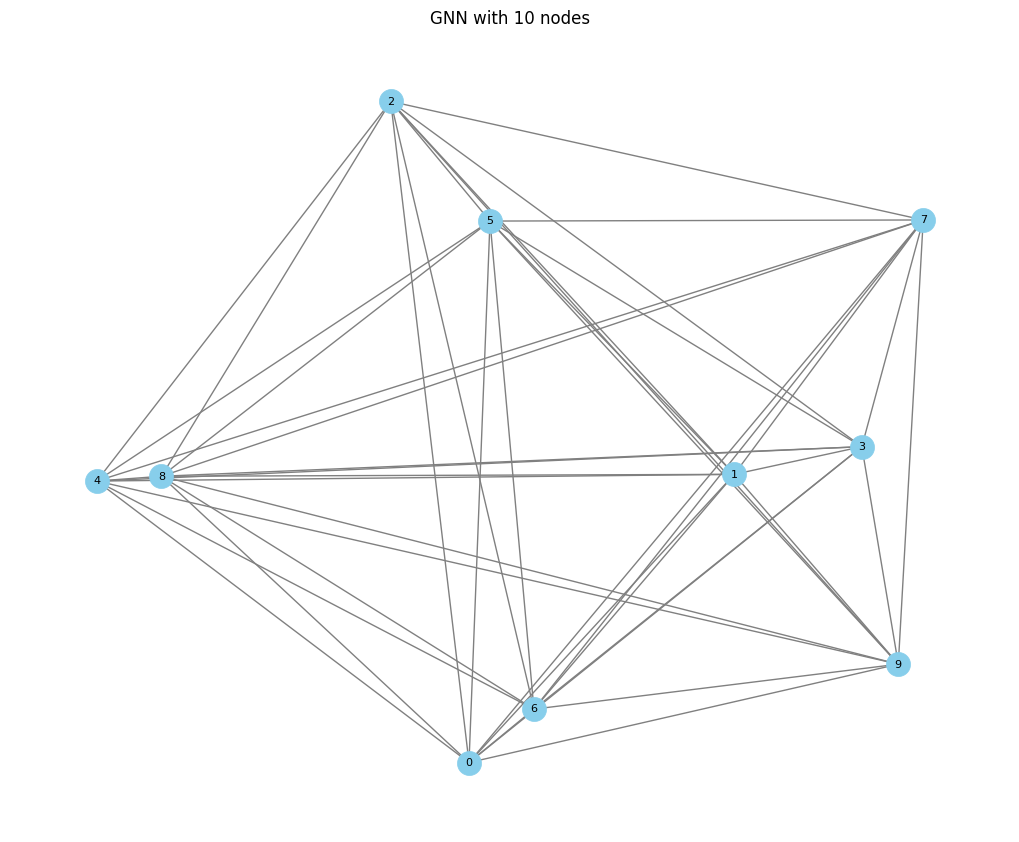

In [63]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_array(route_distances)

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=300, node_color='skyblue', font_size=8, edge_color='gray', linewidths=0.5)
plt.title('GNN with 10 nodes')
plt.show()

In [56]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import layers, models, callbacks
import tensorflow.keras.backend as K

class GNNLayer(layers.Layer):
    # initialises the layer with a number of units
    def __init__(self, units, name=None):
        super(GNNLayer, self).__init__(name=name)
        self.units = units

    # define the weights of the layer
    def build(self, input_shape):

        # weights matrix for transforming input characteristics
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='glorot_uniform',
                                      trainable=True)
        # bias term to adjust the output
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    trainable=True)

    # performs the calculation in the layer
    def call(self, inputs, adjacency_matrix):
        x = tf.matmul(inputs, self.kernel) # multiply the input characteristics (inputs) by the weights (kernel)
        x = tf.matmul(adjacency_matrix, x) # multiply the result by the adjacency matrix, incorporating the network structure
        return tf.nn.relu(x + self.bias) # applies the ReLU activation function


def build_model(num_nodes, num_features):
    node_features_input = tf.keras.Input(shape=(num_nodes, num_features), name='Node_Features') # input for node characteristics
    adj_matrix_input = tf.keras.Input(shape=(num_nodes, num_nodes), name='Adjacency_Matrix') # input for the adjacency matrix

    x = GNNLayer(64, name='GNN_Layer_1')(node_features_input, adj_matrix_input) # apply a transformation with 64 units
    x = layers.BatchNormalization()(x) # normalises activations
    x = layers.Dropout(0.3)(x) # apply dropout to prevent overfitting

    x = GNNLayer(128, name='GNN_Layer_2')(x, adj_matrix_input) # apply a transformation with 128 units 
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten(name='Flatten')(x) # flatten GNN exits
    x = layers.RepeatVector(T-1, name='RepeatVector')(x) # repeat the entry for each timestep, creating a sequence of length T-1

    x = layers.LSTM(256, return_sequences=True, name='LSTM_1')(x) # first LSTM layer with 256 units, returns complete sequences
    x = layers.LSTM(128, return_sequences=False, name='LSTM_2')(x) # second LSTM layer with 128 units, returns the last output in the sequence

    # final dense layer predicting velocity for each node
    output = layers.Dense(num_nodes, name='Output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # the model is compiled with the Adam optimiser and the loss function mse
    model = tf.keras.Model(inputs=[node_features_input, adj_matrix_input], outputs=output, name='GNN_LSTM_Model')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

    return model

# Create the model
num_nodes = route_distances_n.shape[0] # obtains the number of nodes of the normalised distance matrix (N x N)
num_features = speeds_matrix_n.shape[2] # 1 is the number of features per node from the normalised velocity matrix (T, N, 1)
model = build_model(num_nodes, num_features)

# stops training if there is no improvement in validation loss for 10 consecutive periods, restoring the best weights
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# reduces the learning rate by a factor of 0.2 if there is no improvement in validation loss for 5 consecutive epochs, with a minimum of 0.0001
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.summary()

Model: "GNN_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Node_Features       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Adjacency_Matrix    │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GNN_Layer_1         │ (None, 10, 64)    │        128 │ Node_Features[0]… │
│ (GNNLayer)          │                   │            │ Adjacency_Matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ GNN_Layer_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 10, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GNN_Layer_2         │ (None, 10, 128)   │      8,320 │ dropout_8[0][0],  │
│ (GNNLayer)          │                   │            │ Adjacency_Matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ GNN_Layer_2[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 10, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten (Flatten)   │ (None, 1280)      │          0 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RepeatVector        │ (None, 149, 1280) │          0 │ Flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_1 (LSTM)       │ (None, 149, 256)  │  1,573,888 │ RepeatVector[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_2 (LSTM)       │ (None, 128)       │    197,120 │ LSTM_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │      1,290 │ LSTM_2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,781,514 (6.80 MB)

 Trainable params: 1,781,130 (6.79 MB)

 Non-trainable params: 384 (1.50 KB)

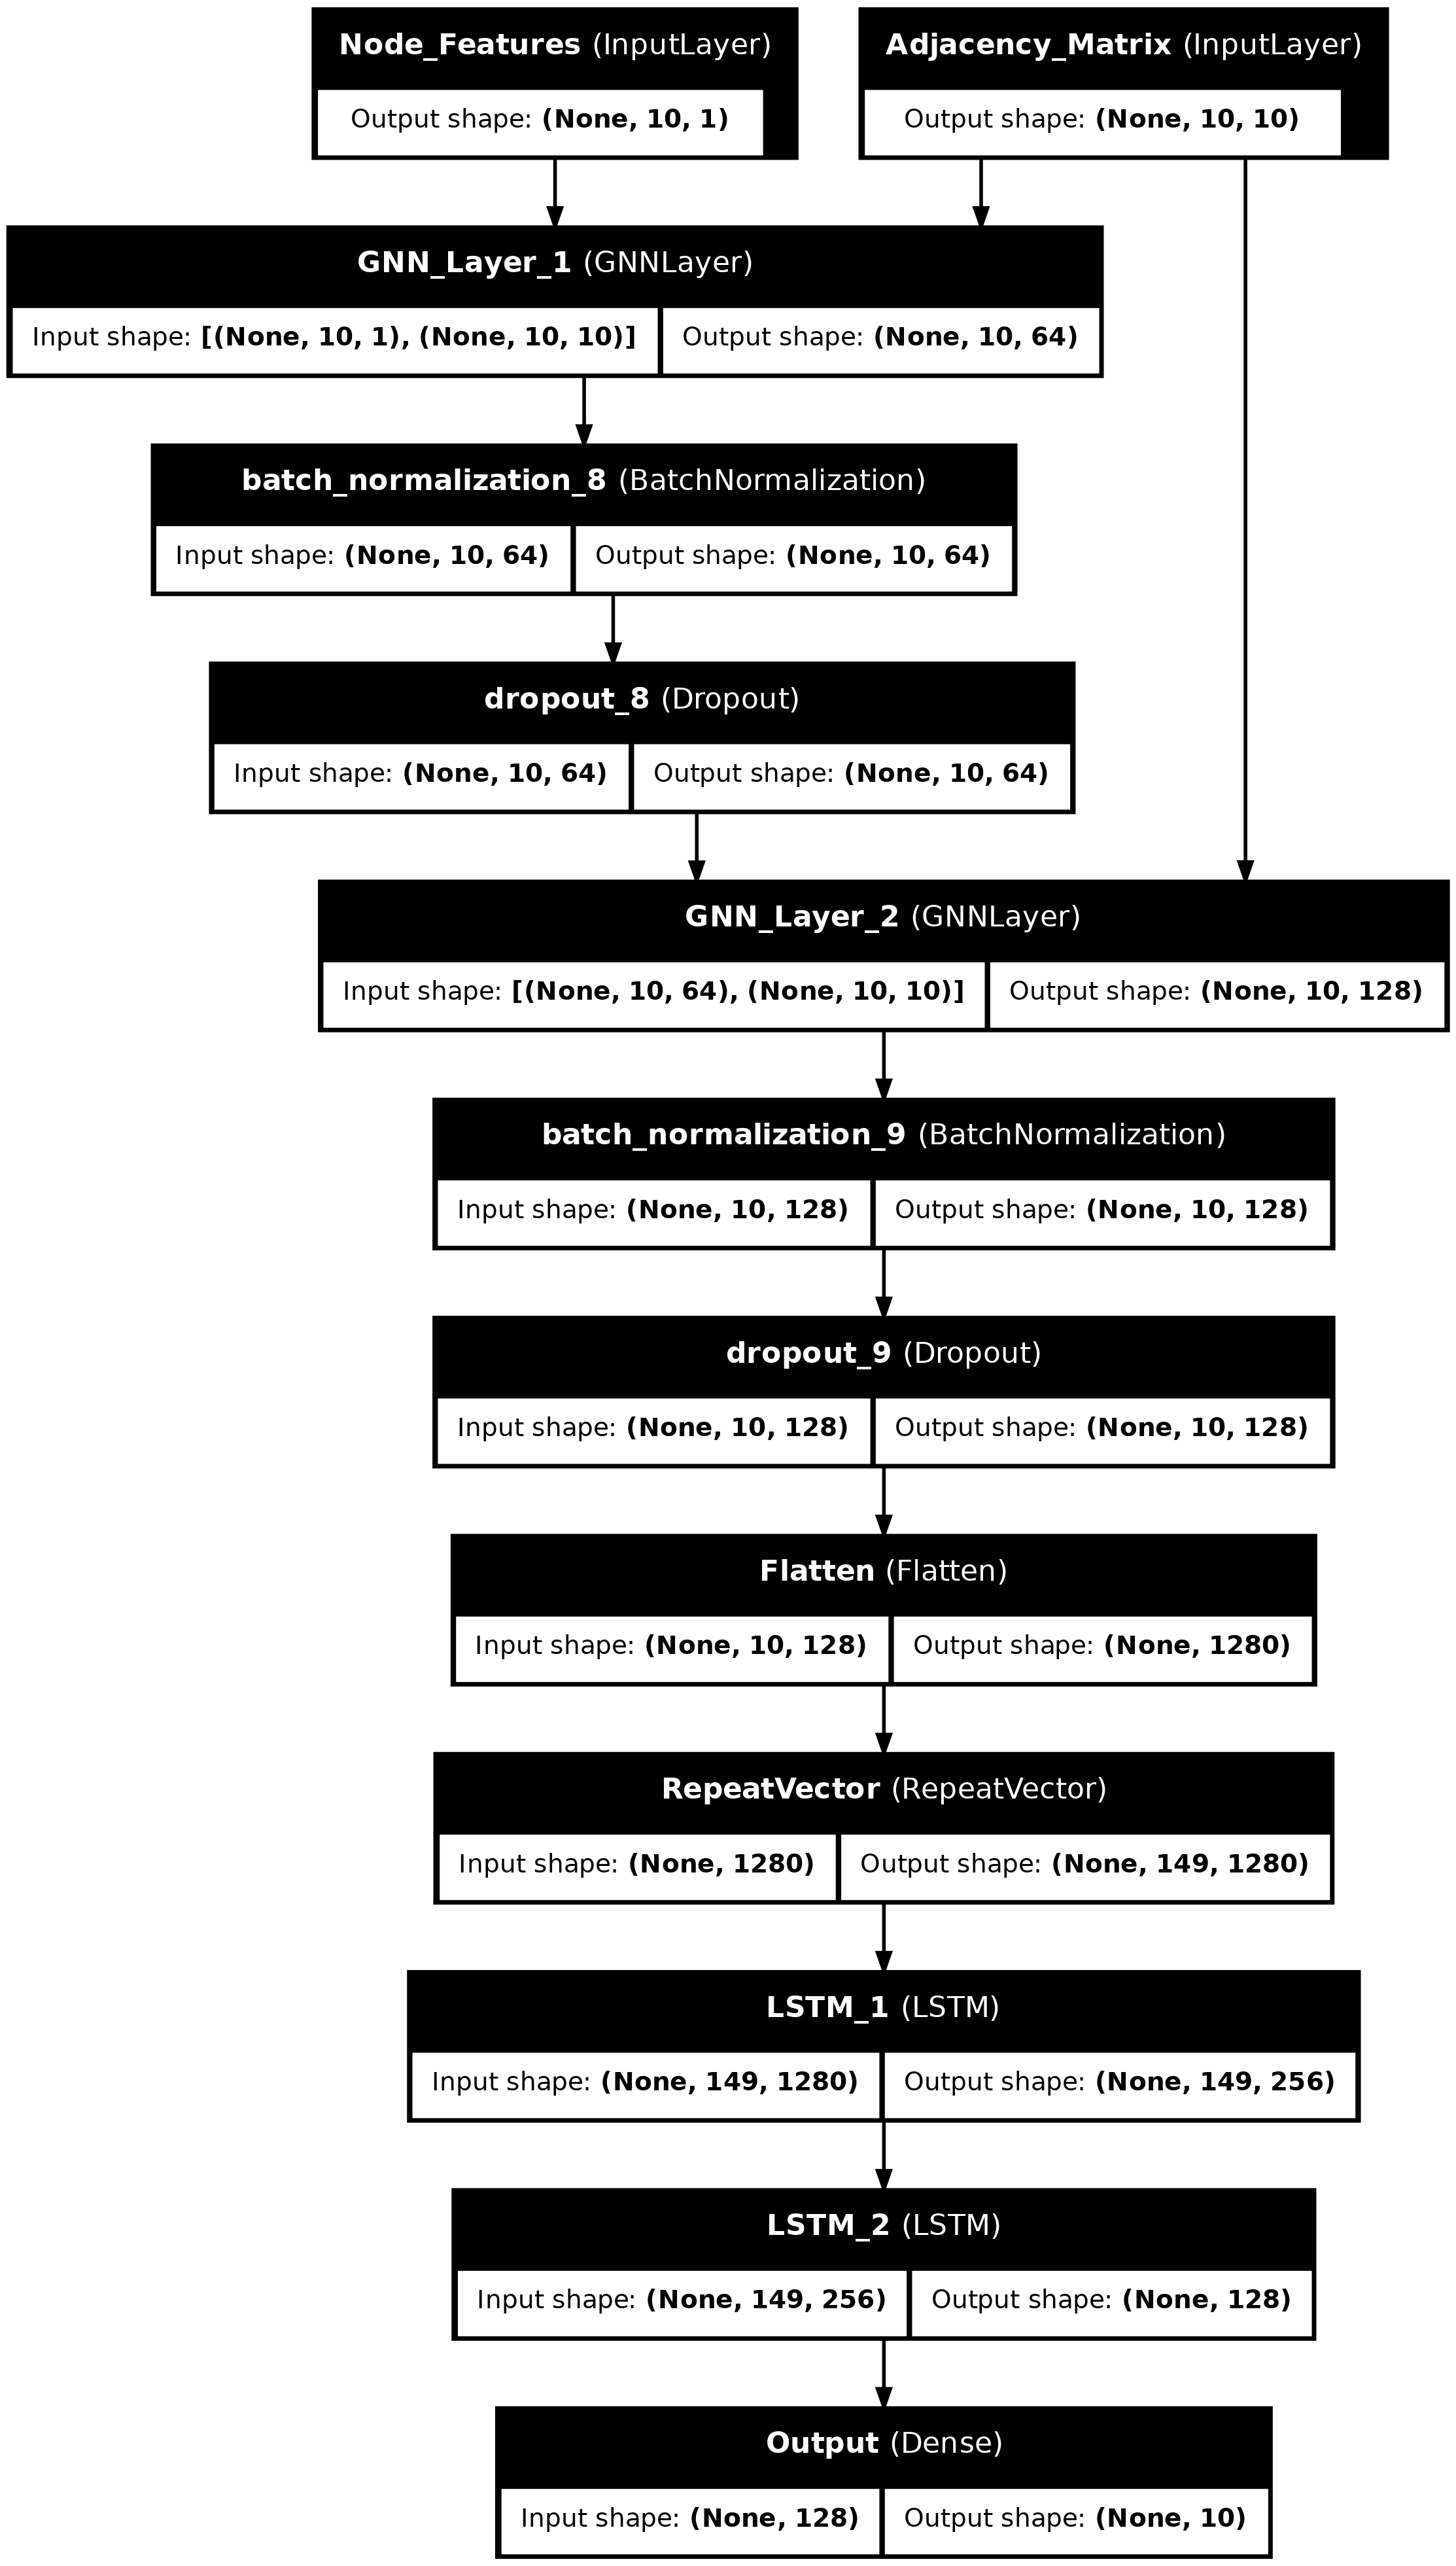

In [58]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='gnn_lstm_model.png', show_shapes=True, show_layer_names=True)

### TRAIN THE MODEL

In [59]:
model.fit([X_train, route_distances_expanded_train], y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 1.3962 - val_loss: 1.3984 - learning_rate: 0.0010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.2133 - val_loss: 1.4423 - learning_rate: 0.0010
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 1.1725 - val_loss: 1.3762 - learning_rate: 0.0010
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.1956 - val_loss: 1.3590 - learning_rate: 0.0010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.1496 - val_loss: 1.3532 - learning_rate: 0.0010
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.1415 - val_loss: 1.3473 - learning_rate: 0.0010
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.0958 - val_loss: 1.3333 - learning_rate: 0.0010
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.1387 - val_loss: 1.3467 - learning_rate: 0.0010
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 1.1304 - val_loss: 1.3412 - learning_rate: 0.0010
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 1.10

### MAKE PREDICTIONS

In [61]:
predictions = model.predict([X_test, route_distances_expanded_test])

print(f'Shape of y_test: {y_test.shape}')
print(f'Shape of predictions: {predictions.shape}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
Shape of y_test: (30, 10, 1)
Shape of predictions: (30, 10)


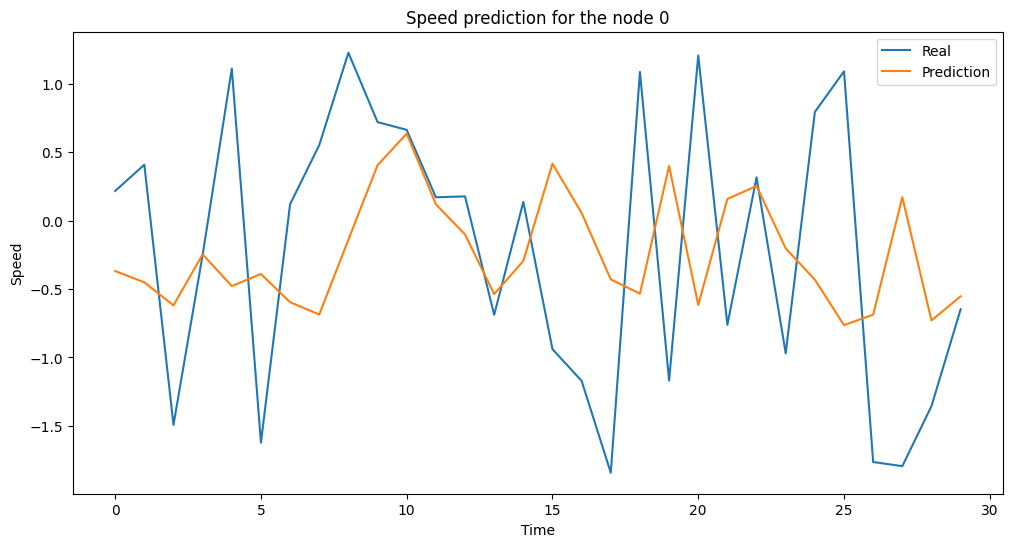

In [62]:
import matplotlib.pyplot as plt

# Select a node to display
node_index = 0

plt.figure(figsize=(12, 6))

# Get rid of the extra dimension
y_test_reshaped = y_test.squeeze(axis=-1)

plt.plot(y_test_reshaped[:, node_index], label='Real')
plt.plot(predictions[:, node_index], label='Prediction')

plt.title(f'Speed prediction for the node {node_index}')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.show()

-------------